Información integrantes del equipo de trabajo

**Nombre y apellidos (Grupo):**

**Nombre y apellidos (Grupo):**

**Nombre y apellidos (Grupo):**

# Modelización:

<img src="esquema.png" width="200">
Un barco enemigo está atacando la costa Este de la isla de las piruletas, sin embargo, dada la distancia de la nave enemiga no somos capaces de determinar su posición. No obstante, a partir de las posiciones donde han caído los proyectiles queremos determinar desde donde nos atacan. El fichero`shots.txt` guarda en dos columnas las coordenadas $(x,y)$ de los cráteres dejados por los proyectiles, medidos respecto de un origen $O$ tal y como se muestra en el esquema (los cráteres tienen un diámetro aproximado de 10 m) . Además, por el tipo de proyectil sabemos que se trata de un cañón que dispara a una velocidad de $320$ m/s y que el ángulo con la horizontal al realizar el disparo es tal que se maximiza el alcance. Bajo estas circunstancias se tiene que los proyectiles deben caer en los puntos que cumplen
$$
(x-d)^2+(y-c)^2=R^2\, ,
$$
donde $R$ es la distancia máxima alcanzada.

### Apartado a:

- Considerando que la altura de lanzamiento y la de impacto son la misma, obtener la expresión de $R$. Usando esta definir una función de python tal que represente el modelo $\tilde{x}(y|d,c)$, donde $d$ y $c$ son los parámetros del modelo.

- A partir del modelo, uno puede construir la función $\chi^2$, definida como
$$
\chi^2(d,c)=\sum_i\frac{[x_i-\tilde{x}(y_i|d,c)]^2}{\sigma_i}\, ,
$$
donde el índice $i$ hace referencia a los datos del archivo `shots.txt`. Definir una función de python que tome como entrada, por lo menos, los parámetros del modelo, es decir, $d$ y $c$ y calcule el valor de $\chi^2(d,c)$.

- Leer los datos contenidos en el fichero `shots.txt` y representar en el plano los puntos de impacto.

In [192]:
# Librerias
from numpy import cos, sin, radians, sqrt, linspace, zeros, loadtxt, array, ndarray, std
from numpy.linalg import norm
from math import pi
from pylab import imshow, scatter, axis, show, xlabel, ylabel, title, colorbar
from random import uniform


# Variables globales
v0, g, diametro = 320.0, 9.81, 10.0 # constantes
v0x, v0y = v0*cos(radians(45)), v0*sin(radians(45))
distanciaMax = v0x*2*v0y/g
shots = loadtxt("shots.txt")
shotsX = shots[:, 0]
shotsY = shots[:, 1]


# Definir funciones
def expectedX(y, d, c):
    """
    Calcula la posición esperada de x.

    Parámetros
    ----------
    y : float
        Coordenada y del disparo.
    d, c : float
        Posiciones del barco que disparó.
    distanciaMax : float
        Distancia máxima que alcanzan los proyectiles.
    """
    global distanciaMax
    return -sqrt(distanciaMax**2 - (y-c)**2) + d

def chiSquared(d, c):
    # esta función asume que shotsX y shotsY ya existen, para simplificar
    global shotsX
    global shotsY
    terminos = []
    for i in range(shotsX.size):
        terminos.append((shotsX[i] - expectedX(shotsY[i], d, c))**2 / diametro)
    return sum(terminos)


def createChiMatrix(d0, d1, c0, c1, N):
    """
    Calcula los valores de `chiSquared` en una matriz [NxN] con los límites de d y c indicados.
    """
    # limites de los parametros d y c
    dLinspace = linspace(d1, d0, N)
    cLinspace = linspace(c0, c1, N)
    chiMatrix = zeros([dLinspace.size, cLinspace.size]) # NOTE (MQ): no es esto equivalente a poner zeros([N,N])?
    for i in range(dLinspace.size): # NOTE (MQ): y lo mismo para aquí con range(N)
        for j in range(cLinspace.size):
            chiMatrix[i, j] = chiSquared(dLinspace[i], cLinspace[j])
    return chiMatrix


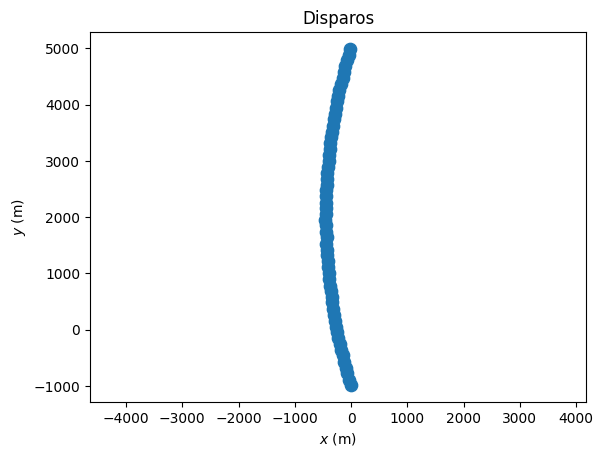

In [193]:
scatter(shotsX, shotsY, pi*(diametro/2)**2) # scatter toma el area para representar la anchura de los puntos
                                            # NOTE (MQ): no estoy seguro de esto, tienen pinta de ser demasiado grandes aquí

# ajustar la presentación del plot
axis('equal')
xlabel('$x$ (m)')
ylabel('$y$ (m)')
title('Disparos')
show()

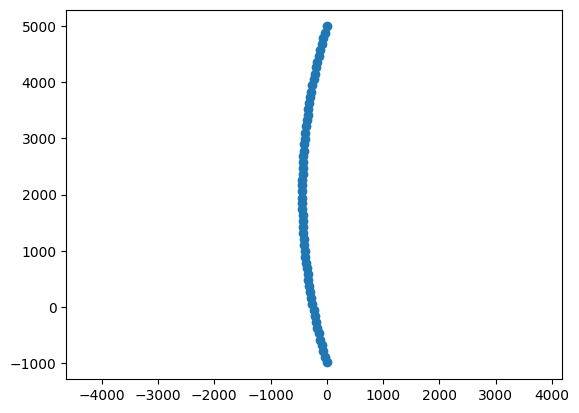

In [195]:
"""
Estimación a ojo de los resultados:

d = 10000 m
c = 2000 m

Si al terminar el código no sale algo similar a esto, puede que esté mal.
"""

exX = expectedX(shotsY, 10000, 2000)
scatter(exX, shotsY)
axis('equal')
show()

- Construir una matriz que contenga el valor de $\chi^2(d,c)$ para distintos valores de los parámetros y representar mediante la función `imshow`. Mediante un proceso manual, ajustar los límites del cuadrado $[d_0,d_1]\times[c_0,c_1]$, para localizar el mínimo de la función $\chi^2(d,c)$ de forma aproximada. **AYUDA**: limitar el valor máximo del colorbar puede ser útil para determinar la región del mínimo.

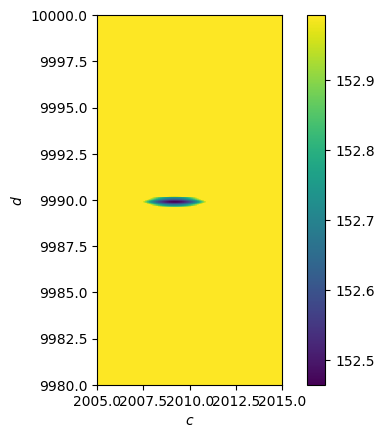

In [196]:
N = 100
d0, d1 = 9980, 10000
c0, c1 = 2005, 2015

chiMatrix = createChiMatrix(d0, d1, c0, c1, N)

umbral = 0.204
imshow(chiMatrix, extent=[c0, c1, d0, d1], vmax=umbral*chiMatrix.max((0,1)))
xlabel('$c$')
ylabel('$d$')
colorbar()
show()

### Apartado b:

Para tratar de localizar el mínimo vamos a usar el método del gradiente, para lo cual necesitamos calcular el gradiente de la función $\chi^2(d,c)$.

- Definir una función que determine el valor del gradiente de la función $\chi^2(d,c)$ en un punto concreto y con un paso espacial determinado. Emplear un método de diferencias finitas para determinar el valor del gradiente.

El método del gradiente para buscar mínimos de una función resulta un proceso iterativo, donde a cada paso actualizamos el valor de los parámetros, de forma que:
$$
\vec{\theta}_{i+1} = \vec{\theta}_i - \gamma \nabla \chi^2(\vec{\theta}_i)\, ,
$$
siendo $\gamma$ el ratio de aprendizaje. Dicho proceso iterativo se suele detener cuando la diferencia en los parámetros entre una iteración y la siguiente es menor que una cierta *tolerancia*.

- Tomando $\gamma\sim 0.01$ definir una función que tome un punto aleatorio del cuadrado $[d_0,d_1]\times[c_0,c_1]$ y realice el proceso iterativo para encontrar el mínimo de la función $\chi^2(d,c)$.

- Usando la función antes definida, repetir el proceso de búsqueda del mínimo para varios puntos iniciales del cuadrado $[d_0,d_1]\times[c_0,c_1]$ y guardar los valores de los parámetros $d$ y $c$ obtenidos cada vez. 

- Mediante el estudio estadístico de los resultados obtenidos determinar el valor de $d$ y $c$, así como el error.

In [197]:
def gradiente(f, x: float, y: float, step: float = 100) -> ndarray[float, float]:
    """
    Calcula el gradiente de una función con dos parámetros en el punto dado.
    Emplea el método de diferencias finitas.

    Parámetros
    ----------
    f : function
        Función a evaluar.
    x, y : float
        Puntos en los que se calcula el gradiente.

    Returns
    -------
    gradiente : ndarray[float, float]
        -> derivadaX : float
            Derivada parcial en x. Primera componente del gradiente.
        -> derivadaY : float
            Derivada parcial en y. Segunda componente del gradiente.
    """
    derivadaX = (f(x+step/2, y) - f(x-step/2, y))/step
    derivadaY = (f(x, y+step/2) - f(x, y-step/2))/step
    return array([derivadaX, derivadaY])

def minFind(f, x0: float, y0: float, rate: float=0.01, tol: float=1e-20, maxIter: int=1000) -> tuple[ndarray, int, float]:
    """
    Halla el valor mínimo de una función.

    Parámetros
    ---------
    f : function
        Función a evaluar.
    x0, y0 : float
        Estimación inicial.
    rate : float
        Ratio de aprendizaje.
    tol : float
        Tolerancia de error para detener la búsqueda del mínimo.
    maxIter : int
        Máximo número de iteraciones para evitar loop infinito.

    Returns
    -------
    r0 : ndarray
        Estimación final del mínimo.
    iter : int
        Iteraciones totales empleadas.
    error : float
        Diferencia entre las dos últimas iteraciones.
    """
    error = tol + 1
    iter = 0
    r0 = array([x0, y0])
    while error > tol and iter < maxIter:
        grad = gradiente(f, r0[0], r0[1])
        r = r0 - rate*grad
        error = norm(rate*grad)
        r0 = r
        iter += 1
    return r0, iter, error

def uniform2D(a0, a1, b0, b1) -> tuple[float, float]:
    """
    Devuelve dos números aleatorios en los rangos [a0, a1) y [b0, b1).
    """
    a = uniform(a0, a1)
    b = uniform(b0, b1)
    return a, b


def minFindStats(f, sampleSize: int, x0, x1, y0, y1, rate: float=0.01, tol: float=1e-20, maxIter: int=1000) -> tuple[float, float, float, float]:
    """
    Halla el valor mínimo con error de una función.

    Parámetros
    ---------
    f : function
        Función a evaluar.
    sampleSize : int
        Número de repeticiones para calcular la estadística.
    x0, x1 : float
        Rango de estimaciones inciales del eje x.
    y0, y1 : float
        Rango de estimaciones inciales del eje y.
    rate : float
        Ratio de aprendizaje.
    tol : float
        Tolerancia de error para detener la búsqueda del mínimo.
    maxIter : int
        Máximo número de iteraciones para evitar loop infinito.

    Returns
    -------
    xMean : float
        Valor mínimo medio de x.
    yMean : float
        Valor mínimo medio de y.
    xStd : float
        Desviación estándar de x.
    yStd : float
        Desviación estándar de y.
    x : ndarray[float]
        Valores obtenidos de x en cada iteración.
    y : ndarray[float]
        Valores obtenidos de y en cada iteración.
    """
    x = zeros([sampleSize], float)
    y = zeros([sampleSize], float)
    for i in range(sampleSize):
        xInit, yInit = uniform2D(x0, x1, y0, y1)
        min = minFind(f, xInit, yInit, rate, tol, maxIter)[0]
        x[i], y[i] = min[0], min[1]
        print(f'iter: {i+1}/{sampleSize}', end='\r')

    xMean = sum(x)/x.size
    yMean = sum(y)/y.size
    xStd = std(x)
    yStd = std(y)
    return xMean, yMean, xStd, yStd, x, y


In [198]:
print(minFind(chiSquared, 14000, 2000))
print(minFind(chiSquared, 9000, 3000))
print(minFind(chiSquared, 100, 300))

(array([9989.90762594, 2008.89067753]), 1000, 0.0010004870206813312)
(array([9989.81593308, 2042.59291695]), 1000, 0.11640761706023128)
(array([9989.25213367, 1888.92620463]), 1000, 0.41898447592966986)


In [201]:
d0, d1 = 9000, 11000
c0, c1 = 1800, 2200
sampleSize = 100
dMean, cMean, dStd, cStd, d, c = minFindStats(chiSquared, sampleSize, d0, d1, c0, c1, tol=1e-5, maxIter=100)

print(f'Coordenadas finales:\nd = ({round(dMean,2)}±{round(dStd,2)})\nc = ({round(cMean,2)}±{round(cStd,2)})')

Coordenadas finales:
d = (9989.56±0.3)
c = (2010.77±80.45)
